In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install 'git+https://github.com/facebookresearch/detectron2.git'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-g3c44ibi
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-g3c44ibi
  Resolved https://github.com/facebookresearch/detectron2.git to commit e020497c85873c2b811ac87dd2e4a34a806e4c2b
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 89.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 17.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for detectron2: filen

In [ ]:
#!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data.catalog import DatasetCatalog

import numpy as np
import time
from sklearn.model_selection import train_test_split
#from tqdm.autonotebook import tqdm, trange

import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn


BATCH_SIZE = 32
import torch._utils
import torch
import argparse
import torch.nn as nn
import torch.optim as optim
import time
from tqdm.auto import tqdm

In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances('data_train', {}, '/content/drive/MyDrive/Object_detector_TCS/via_project_29Apr2023_10h44m_coco.json', '/content/drive/MyDrive/Object_detector_TCS/archive_jpg')
# register_coco_instances("my_dataset_val", {}, "/content/valid/_annotations.coco.json", "/content/valid")
# register_coco_instances("my_dataset_test", {}, "/content/test/_annotations.coco.json", "/content/test")

In [ ]:
register_coco_instances("my_dataset_test", {}, "/content/drive/MyDrive/Object_detector_TCS/via_project_29Apr2023_10h44m_coco.json", "/content/drive/MyDrive/Object_detector_TCS/test")

[05/03 06:29:25 d2.data.datasets.coco]: Loaded 146 images in COCO format from /content/drive/MyDrive/Object_detector_TCS/via_project_29Apr2023_10h44m_coco.json
/content/drive/MyDrive/Object_detector_TCS/archive_jpg/IMG_4424.jpg


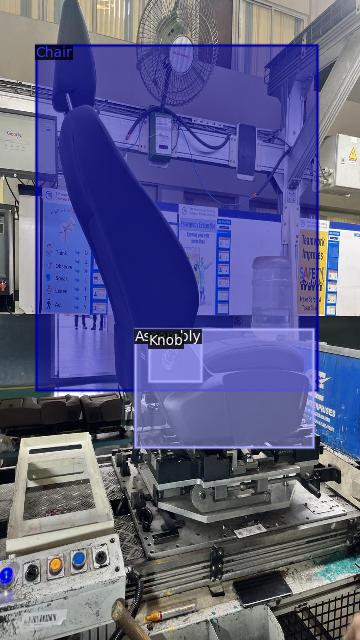

/content/drive/MyDrive/Object_detector_TCS/archive_jpg/IMG_4184.jpg


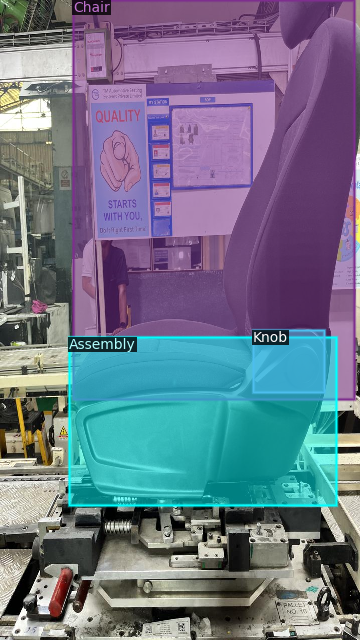

/content/drive/MyDrive/Object_detector_TCS/archive_jpg/IMG_4229.jpg


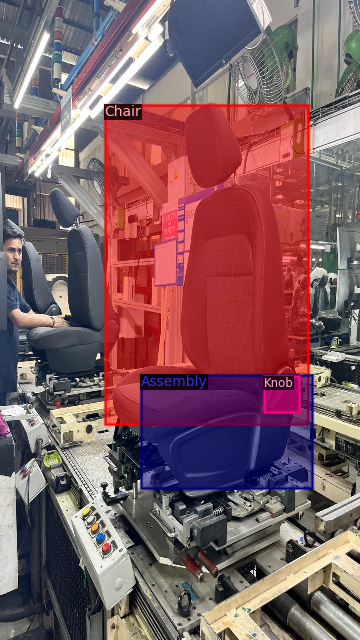

In [ ]:
my_dataset_train_metadata = MetadataCatalog.get("data_train")
dataset_dicts = DatasetCatalog.get("data_train")

import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    print(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [ ]:
dataset_dicts

[{'file_name': '/content/drive/MyDrive/Object_detector_TCS/archive_jpg/IMG_4183.jpg',
  'height': 1280,
  'width': 720,
  'image_id': 1,
  'annotations': [{'iscrowd': 0,
    'bbox': [126, 13, 495, 895],
    'category_id': 4,
    'segmentation': [[126, 13, 621, 13, 621, 908, 126, 908]],
    'bbox_mode': <BoxMode.XYWH_ABS: 1>},
   {'iscrowd': 0,
    'bbox': [91, 797, 456, 291],
    'category_id': 5,
    'segmentation': [[91, 797, 547, 797, 547, 1088, 91, 1088]],
    'bbox_mode': <BoxMode.XYWH_ABS: 1>},
   {'iscrowd': 0,
    'bbox': [417, 813, 116, 90],
    'category_id': 6,
    'segmentation': [[417, 813, 533, 813, 533, 903, 417, 903]],
    'bbox_mode': <BoxMode.XYWH_ABS: 1>}]},
 {'file_name': '/content/drive/MyDrive/Object_detector_TCS/archive_jpg/IMG_4184.jpg',
  'height': 1280,
  'width': 720,
  'image_id': 2,
  'annotations': [{'iscrowd': 0,
    'bbox': [146, 1, 562, 797],
    'category_id': 4,
    'segmentation': [[146, 1, 708, 1, 708, 798, 146, 798]],
    'bbox_mode': <BoxMode.XYWH

In [ ]:
from detectron2.engine import DefaultTrainer
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("data_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 7  # only has one class (Vehicle registration plate). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
# trainer = DefaultTrainer(cfg)
# trainer.resume_or_load(resume=False)
# trainer.train()

In [ ]:
cfg.OUTPUT_DIR

'./output'

# Inference script

In [ ]:
# cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "/content/output/model_final.pth")
cfg.MODEL.WEIGHTS = '/content/drive/MyDrive/Object_detector_TCS/model_final.pth'
cfg.DATASETS.TEST = ("my_dataset_test", )
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8   # set the testing threshold for this model
predictor = DefaultPredictor(cfg)
test_metadata = MetadataCatalog.get("my_dataset_test")

from detectron2.utils.visualizer import ColorMode
import glob

# for imageName in glob.glob('/content/drive/MyDrive/Object_detector_TCS/test/*jpg'):
#   im = cv2.imread(imageName)
#   outputs = predictor(im)
#   v = Visualizer(im[:, :, ::-1],
#                 metadata=test_metadata, 
#                 scale=0.8
#                  )
#   out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
#   cv2_imshow(out.get_image()[:, :, ::-1])


[05/03 06:30:00 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/Object_detector_TCS/model_final.pth ...


In [ ]:
# the computation device
device = ('cuda' if torch.cuda.is_available() else 'cpu')
# list containing all the class labels
labels = [
    'knob', 'No knob', 
    ]

In [ ]:
import torchvision.models as models
import torch._utils
resnet18 = models.resnet18(pretrained=True)
resnet18.fc = nn.Linear(in_features=512, out_features=2, bias=True)
model_loaded = resnet18
model_loaded.load_state_dict(torch.load('/content/drive/MyDrive/Object_detector_TCS/Classifier/Classifier/classifier_01.pth'))
model_loaded.eval()
model_loaded.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 217MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
transform_inf = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(300),
    transforms.ToTensor(),
#     transforms.Normalize(
#         mean=[0.5, 0.5, 0.5],
#         std=[0.5, 0.5, 0.5]
#     )
])  


In [ ]:
import cv2
from google.colab.patches import cv2_imshow
imageName = '/content/drive/MyDrive/Object_detector_TCS/inference_images/20230503_114009.jpg'
image = cv2.imread(imageName)
# get the ground truth class
# gt_class = args['input'].split('/')[-2]
orig_image = image.copy()
# convert to RGB format
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = transform_inf(image)
# add batch dimension
image = torch.unsqueeze(image, 0)
with torch.no_grad():
    outputs = model_loaded(image.to(device))
output_label = torch.topk(outputs,1)
pred_class = labels[int(output_label.indices)]

# cv2.putText(orig_image, 
#     f"Pred: {pred_class}",
#     (10, 55),
#     cv2.FONT_HERSHEY_SIMPLEX, 
#     0.6, (0, 0, 255), 2, cv2.LINE_AA
# )
# print(f"GT: 'ground truth', pred: {pred_class}")
# cv2_imshow(orig_image)
# cv2.waitKey(0)
# output_label

In [ ]:
pred_class

'knob'

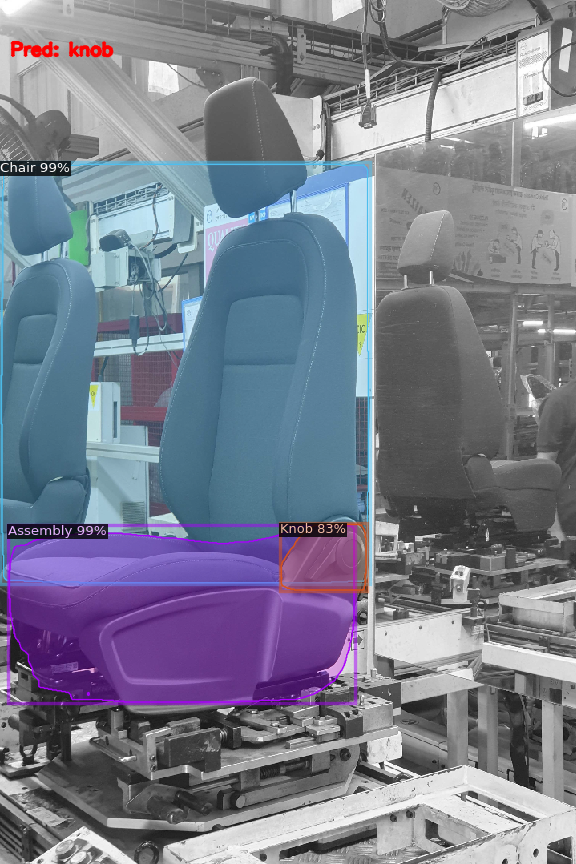

In [ ]:
# imageName = '/content/drive/MyDrive/Object_detector_TCS/test/IMG_4184.jpg'
im = cv2.imread(imageName)
im = cv2.resize(im, (720,1080))
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1],
                metadata=my_dataset_train_metadata, 
                scale=0.8,
               instance_mode=ColorMode.IMAGE_BW 
                 )
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
img = out.get_image()[:, :, ::-1].copy()
cv2.putText(img, 
    f"Pred: {pred_class}",
    (10, 55),
    cv2.FONT_HERSHEY_SIMPLEX, 
    0.6, (0, 0, 255), 2, cv2.LINE_AA
)
cv2_imshow(img)

In [ ]:
out